In [1]:
import os
os.environ["Method"] = "stochastic"
import nonlinear_solver_initial as solver     #solves opt. problems for terminal VF
import nonlinear_solver_iterate as solviter   #solves opt. problems during VFI
import interpolation as interpol              #interface to sparse grid library/terminal VF
import interpolation_iter as interpol_iter    #interface to sparse grid library/iteration
import postprocessing as post
import TasmanianSG                            #sparse grid library
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML

In [2]:
paramL = dict()
# Depth of "Classical" Sparse grid
paramL['iDepth']=1
paramL['iOut']=1         # how many outputs
paramL['which_basis'] = 1 #linear basis function (2: quadratic local basis)

# control of iterations
paramL['numstart'] = 0   # which is iteration to start (numstart = 0: start from scratch, number=/0: restart)
paramL['numits'] = 5    # which is the iteration to end

# How many random points for computing the errors
paramL['No_samples'] = 1000

### Model Paramters
paramL['n_agents']=2  # number of continuous dimensions of the model

paramL['beta']=0.8
paramL['rho']=0.95
paramL['zeta']=0.5
paramL['psi']=0.36
paramL['gamma']=2.0
paramL['delta']=0.025
paramL['eta']=1
paramL['big_A']=(1.0-paramL['beta'])/(paramL['psi']*paramL['beta'])

# Ranges For States
paramL['range_cube']=5 # range of [0..1]^d in 1D
paramL['k_bar']=0.2
paramL['k_up']=3.0

# Ranges for Controls
paramL['c_bar']=1e-2
paramL['c_up']=10000.0

paramL['l_bar']=1e-2
paramL['l_up']=1.0

paramL['inv_bar']=1e-2
paramL['inv_up']=10000.0

# Stochastic
paramL['theta_list'] = [0.9, 0.95, 1.00, 1.05, 1.10]
paramL['curr_theta'] = 1.00

In [3]:
def get_iteration_list(iteration):
    output = []
    for shock in range(5):
        v=TasmanianSG.TasmanianSparseGrid()
        v.read("valnew_1." + str(iteration) +'.s{}'.format(shock)+ ".txt")
        output.append(v)
    
    return output

def main():
    for shock in range(5):
        paramL['curr_theta'] = paramL['theta_list'][shock]
        valnew=TasmanianSG.TasmanianSparseGrid()
        valnew=interpol.sparse_grid(paramL)
        valold = TasmanianSG.TasmanianSparseGrid()
        valold = valnew
        valnew.write("valnew_1." + str(paramL['numstart']) +".s{}".format(shock)+ ".txt") #write file to disk for restart


    for i in range(paramL['numstart']+1, paramL['numits']+1):
        for shock in range(5):
            paramL['curr_theta'] = paramL['theta_list'][shock]
            valnew=TasmanianSG.TasmanianSparseGrid()
            output = get_iteration_list(i-1)
            valnew=interpol_iter.sparse_grid_iter(paramL, list(output))
            valold = TasmanianSG.TasmanianSparseGrid()
            valold = valnew
            valnew.write("valnew_1."+str(i)+".s{}".format(shock)+".txt")


    avg_err=post.ls_error(paramL)
    
    
    return output

In [4]:
output = main()

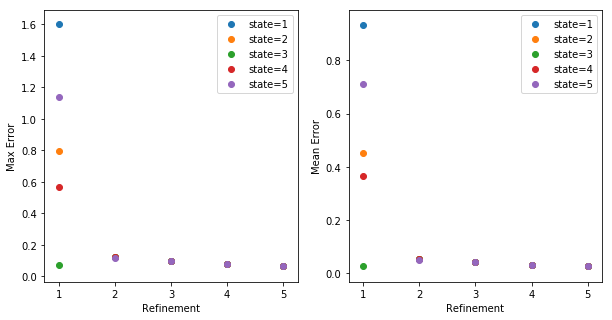

In [5]:
plt.close()
def draw_plots():
    
    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    for i in range(5):
        errors = np.loadtxt('errors.s{}.txt'.format(i))
        refinement = errors[:,0]
        error_max = errors[:,1]
        error_mean = errors[:,2]
        ax[0].scatter(refinement, error_max, label='state={}'.format(i+1))
        ax[0].set_xlabel('Refinement')
        ax[0].set_ylabel('Max Error')

        ax[1].scatter(refinement, error_mean, label='state={}'.format(i+1))
        ax[1].set_xlabel('Refinement')
        ax[1].set_ylabel('Mean Error')
    
    ax[0].legend()
    ax[1].legend()
    
    return fig, ax

fig, ax = draw_plots()
plt.show()

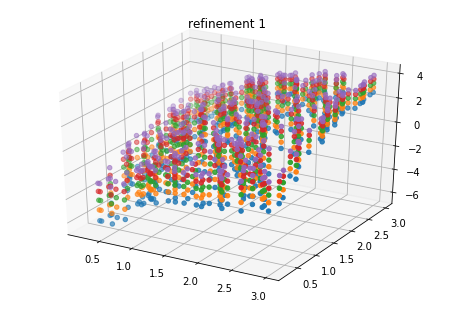

In [6]:
def draw_3d_graph(refinement, num_points=300, n_agents=2):
    fig = plt.figure()
    ax = Axes3D(fig)
    np.random.seed(0)
    
    unif=np.random.rand(num_points, n_agents)
    k_sample=paramL['k_bar']+(unif)*(paramL['k_up']-paramL['k_bar'])
    

    label = 'refinement {0}'.format(refinement+1)
    for j in range(5):
        v=TasmanianSG.TasmanianSparseGrid()
        v.read("valnew_1." + str(refinement) +'.s{}'.format(j)+ ".txt")
        z=v.evaluateBatch(k_sample) 


        ax.scatter(k_sample[:,0], k_sample[:,1],z, label=j)

    ax.set_title(label)
    
    return fig, ax

fig, ax = draw_3d_graph(0)

plt.show()

In [7]:
def draw_3d_graph(num_points=300, n_agents=2):
    fig = plt.figure()
    ax = Axes3D(fig)
    np.random.seed(0)
    
    unif=np.random.rand(num_points, n_agents)
    k_sample=paramL['k_bar']+(unif)*(paramL['k_up']-paramL['k_bar'])
    

    def update(i):
        label = 'refinement {0}'.format(i+1)
        ax = Axes3D(fig)
        for j in range(5):
            v=TasmanianSG.TasmanianSparseGrid()
            v.read("valnew_1." + str(i) +'.s{}'.format(j)+ ".txt")
            z=v.evaluateBatch(k_sample) 
            ax.scatter(k_sample[:,0], k_sample[:,1],z, label=j)

        ax.set_title(label)

    anim = FuncAnimation(fig, update, frames=np.arange(0, 5), interval=1000)
    return anim

anim = draw_3d_graph()
HTML(anim.to_jshtml())